In [ ]:
import requests
import os
import re
import random
import urllib.request
import numpy as np
np.random.seed(seed=123) # Do not change
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import nltk
from nltk.tokenize import word_tokenize

# Download required NLTK data (run once)
nltk.download('punkt')
nltk.download('punkt_tab')

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

with open('shakespeare.txt', 'r', encoding='utf-8') as file:
    shakespeare_text = file.read()

with open('spenser.txt', 'r', encoding='utf-8') as file:
    spenser_text = file.read()

with open('syllable_dict.txt', 'r', encoding='utf-8') as file:
    syllables = file.read()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


Preprocessing and Imports

In [ ]:
def tokenize_with_nltk(data):
    sonnets = data.split('\n\n')
    all_sonnets = []
    word_to_idx = {}
    idx_to_word = {}
    rhyme_dict = {}
    keep_apostrophes = {"'gainst", "'greeing", "'scaped", "'tis", "'twixt", "th'"}

    # Initialize with newline marker
    word_to_idx["\n"] = 0
    idx_to_word[0] = "\n"

    for sonnet in sonnets:
        lines = sonnet.split('\n')
        sonnet_lines = []
        last_words_in_sonnet = []  # Track the last word of each line

        # Process only non-empty lines
        valid_lines = []
        for line in lines:
            line = line.strip()
            if not line.isdigit() and line:
                valid_lines.append(line)

        # Process each valid line
        for line in valid_lines:
            tokens = line.lower().split()
            cleaned_tokens = []

            for token in tokens:
                # Clean the token
                cleaned_token = re.sub(r'[^\w\s\'-]', '', token)

                # Handle apostrophes
                if cleaned_token not in keep_apostrophes and cleaned_token[0] == "'":
                    cleaned_token = cleaned_token[1:]
                if cleaned_token not in keep_apostrophes and cleaned_token[-1] == "'":
                    cleaned_token = cleaned_token[:-1]

                if cleaned_token:
                    cleaned_tokens.append(cleaned_token)
                    if cleaned_token not in word_to_idx:
                        word_to_idx[cleaned_token] = len(word_to_idx)
                        idx_to_word[len(word_to_idx) - 1] = cleaned_token

            if cleaned_tokens:
                # Store the last word of this line for rhyming
                last_words_in_sonnet.append(cleaned_tokens[-1])

                # Add tokens to sonnet_lines
                for token in cleaned_tokens:
                    sonnet_lines.append(word_to_idx[token])
                sonnet_lines.append(0)  # End of line marker

        # Add completed sonnet to all_sonnets
        all_sonnets.append(sonnet_lines)

        # Process rhyming pairs if we have enough lines
        if len(last_words_in_sonnet) >= 14:
            # Define the Shakespearean rhyme scheme pairs
            rhyming_pairs = [
                (0, 2), (1, 3),      # ABAB
                (4, 6), (5, 7),      # CDCD
                (8, 10), (9, 11),    # EFEF
                (12, 13)             # GG
            ]

            for i, j in rhyming_pairs:
                if i < len(last_words_in_sonnet) and j < len(last_words_in_sonnet):
                    word1 = last_words_in_sonnet[i]
                    word2 = last_words_in_sonnet[j]

                    # Add to rhyming dictionary
                    if word1 not in rhyme_dict:
                        rhyme_dict[word1] = set()
                    if word2 not in rhyme_dict:
                        rhyme_dict[word2] = set()

                    rhyme_dict[word1].add(word2)
                    rhyme_dict[word2].add(word1)

    # Convert sets to lists for easier random selection
    for word in rhyme_dict:
        rhyme_dict[word] = list(rhyme_dict[word])

    return all_sonnets, word_to_idx, idx_to_word, rhyme_dict

tokenized_lines, word_to_idx, idx_to_word, rhyme_dict = tokenize_with_nltk(shakespeare_text)
print(tokenized_lines)
print(word_to_idx)
print(idx_to_word)
print(rhyme_dict)

[[1, 2, 3, 4, 5, 6, 0, 7, 8, 9, 10, 11, 12, 13, 0, 14, 15, 16, 17, 18, 19, 20, 21, 0, 22, 23, 24, 11, 25, 22, 26, 0, 14, 27, 28, 29, 30, 31, 32, 33, 0, 34, 35, 36, 37, 38, 39, 40, 0, 41, 42, 43, 44, 45, 46, 0, 35, 47, 35, 48, 29, 35, 49, 47, 50, 51, 0, 27, 7, 52, 53, 16, 54, 55, 56, 0, 57, 58, 59, 29, 16, 60, 61, 0, 62, 30, 31, 63, 64, 35, 65, 0, 57, 23, 66, 67, 68, 69, 70, 0, 71, 16, 72, 73, 74, 75, 76, 77, 0, 29, 78, 16, 54, 79, 19, 16, 80, 57, 81, 0], [82, 83, 84, 85, 86, 35, 87, 0, 57, 88, 89, 90, 69, 35, 9, 91, 0, 35, 92, 93, 94, 95, 96, 97, 53, 0, 98, 77, 42, 99, 100, 101, 102, 103, 104, 0, 105, 106, 107, 44, 108, 35, 109, 46, 0, 44, 108, 16, 110, 101, 35, 111, 112, 0, 29, 113, 62, 30, 31, 89, 114, 33, 0, 115, 116, 117, 118, 57, 119, 120, 0, 121, 122, 123, 120, 124, 35, 9, 125, 0, 126, 27, 127, 128, 75, 129, 130, 101, 131, 0, 85, 132, 133, 134, 57, 135, 133, 136, 137, 0, 138, 22, 109, 19, 139, 30, 0, 75, 115, 29, 77, 140, 141, 82, 27, 52, 136, 0, 57, 142, 35, 143, 144, 82, 27, 14

In [ ]:
def make_dict(data):
    lines = data.split('\n')
    word_to_syllable = {}
    for i in range(len(lines) - 1):
      line = lines[i].strip()
      arr = line.split()
      word = arr[0]
      word_to_syllable[word] = []
      if len(arr) == 2:
        word_to_syllable[word].append(int(arr[1]))
      else:
        word1 = arr[1]
        word2 = arr[2]
        if word1[0] == 'E':
          word_to_syllable[word].append(int(word2))
          word_to_syllable[word].append(int(word1[1:]))
        elif word2[0] == 'E':
          word_to_syllable[word].append(int(word1))
          word_to_syllable[word].append(int(word2[1:]))
        else:
          if word1 > word2:
            word_to_syllable[word].append(int(word1))
            word_to_syllable[word].append(int(word2))
          else:
            word_to_syllable[word].append(int(word2))
            word_to_syllable[word].append(int(word1))

    return word_to_syllable

syllable_dict = make_dict(syllables)
syllable_dict["\n"] = [0]
print(syllable_dict)

{"'gainst": [1], "'greeing": [2, 1], "'scaped": [1], "'tis": [1], "'twixt": [1], 'a': [1], 'a-doting': [3, 2], 'abhor': [2], 'abide': [2], 'able': [2], 'about': [2], 'above': [2], 'absence': [2], 'absent': [2], 'abundance': [3], 'abundant': [3], 'abuse': [2], 'abused': [2], 'abuses': [3], 'abysm': [2], 'accents': [2], 'acceptable': [4], 'acceptance': [3], 'accessary': [4], 'accident': [3], 'accidents': [3], 'account': [2], 'accumulate': [4], 'accuse': [2], 'accusing': [3], 'achieve': [2], 'acknowledge': [3], 'acquaintance': [3], 'acquainted': [3, 2], 'act': [1], 'action': [2], 'active': [2], 'actor': [2], 'add': [1], 'added': [2], "adder's": [2], 'addeth': [2], 'adding': [2], 'addition': [3], 'adieu': [2], 'adjunct': [2], 'admire': [2], 'admired': [3], 'admiring': [3], 'admit': [2], 'admitted': [3], 'adonis': [3], 'adore': [2], 'adulterate': [3], 'advance': [2], 'advantage': [3], 'adverse': [2], 'advised': [2], 'advocate': [3], 'afar': [2], 'affable': [3], 'affairs': [2], 'affections':

Unsupervised HMM

In [ ]:

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          probs[1][i] = self.A_start[i] * self.O[i][x[0]]
          seqs[1][i] = str(i)


        for d in range(2, M + 1):

          for curr_state in range(self.L):
            max_prob = float("-inf")
            best_seq = ""

            for prev_state in range(self.L):
              prob = probs[d-1][prev_state] * self.A[prev_state][curr_state] * self.O[curr_state][x[d-1]]
              if prob >= max_prob:
                max_prob = prob
                best_seq = seqs[d-1][prev_state] + str(curr_state)

            probs[d][curr_state] = max_prob
            seqs[d][curr_state] = best_seq

        max_seq = seqs[M][np.argmax(probs[M])]
        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          alphas[1][i] = self.A_start[i] * self.O[i][x[0]]

        for d in range(2, M + 1):

          for curr_state in range(self.L):
            prob = 0
            for prev_state in range(self.L):
              prob += (self.O[curr_state][x[d-1]] * (alphas[d-1][prev_state] * self.A[prev_state][curr_state]))

            alphas[d][curr_state] = prob

          if normalize:
            denom = np.sum(alphas[d])
            alphas[d] = [alpha/denom for alpha in alphas[d]]


        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          betas[M][i] = 1

        for d in range(M - 1, -1, -1):

          for curr_state in range(self.L):
            prob = 0
            for next_state in range(self.L):
                if d == 0:
                  prob += (betas[d+1][next_state] * self.A_start[next_state] * self.O[next_state][x[d]])
                else:
                  prob += (betas[d+1][next_state] * self.A[curr_state][next_state] * self.O[next_state][x[d]])

            betas[d][curr_state] = prob

          if normalize:
            denom = np.sum(betas[d])
            betas[d] = [beta/denom for beta in betas[d]]

        return betas


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''

        for i in range(N_iters):
          A_numer = np.zeros((self.L, self.L))
          A_denom = np.zeros((self.L, self.L))
          O_numer = np.zeros((self.L, self.D))
          O_denom = np.zeros((self.L, self.D))

          for x in X:
            alphas = self.forward(x, normalize=True)
            betas = self.backward(x, normalize=True)
            M = len(x)

            for d in range(1, M + 1):
              prob_OAd = np.array([alphas[d][curr_state] * betas[d][curr_state] for curr_state in range(self.L)])
              prob_OAd /= np.sum(prob_OAd)

              for curr_state in range(self.L):
                O_numer[curr_state][x[d-1]] += prob_OAd[curr_state]
                O_denom[curr_state] += prob_OAd[curr_state]
                if d != M:
                  A_denom[curr_state] += prob_OAd[curr_state]

            for d in range(1, M):
              prob_An = np.array([[alphas[d][curr_state] \
                                  * self.O[next_state][x[d]] \
                                  * self.A[curr_state][next_state] \
                                  * betas[d+1][next_state] \
                                  for next_state in range(self.L)] \
                                  for curr_state in range(self.L)])
              prob_An /= np.sum(prob_An)

              for curr_state in range(self.L):
                for next_state in range(self.L):
                  A_numer[curr_state][next_state] += prob_An[curr_state][next_state]

          self.A = A_numer / A_denom
          self.O = O_numer / O_denom


    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        # Initialize Random Start State
        # state = prev_state
        # if prev_state is None:
        state = np.random.randint(0, self.L)

        for d in range(M):
          emission.append(np.random.choice(list(range(self.D)), p = self.O[state]))
          states.append(state)
          state = np.random.choice(list(range(self.L)), p = self.A[state])

        return emission, states

    def generate_emission_lines(self, num_lines, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        # Initialize Random Start State
        # state = prev_state
        # if prev_state is None:
        state = np.random.randint(0, self.L)
        total = 0

        while total < num_lines:
          emission.append(np.random.choice(list(range(self.D)), p = self.O[state]))
          states.append(state)
          state = np.random.choice(list(range(self.L)), p = self.A[state])
          if emission[-1] == 0:
            total += 1

        return emission, states

    def generate_sonnet_backwards(self, rhyme_dict, word_to_idx, idx_to_word, seed=None):
      """Generate a Shakespearean sonnet backwards, generating each line until a newline character"""
      rng = np.random.default_rng(seed=seed)

      # Track ending words for rhyming
      last_words = []

      # Final result
      full_emission = []
      full_states = []

      # Define sonnet structure - which lines rhyme with which
      # ABAB CDCD EFEF GG rhyme scheme
      first_occurrence = {0, 1, 4, 5, 8, 9, 12}  # Lines that introduce a new rhyme
      rhyme_pairs = {
          2: 0,  # Line 3 rhymes with line 1
          3: 1,  # Line 4 rhymes with line 2
          6: 4,  # Line 7 rhymes with line 5
          7: 5,  # Line 8 rhymes with line 6
          10: 8, # Line 11 rhymes with line 9
          11: 9, # Line 12 rhymes with line 10
          13: 12 # Line 14 rhymes with line 13
      }

      # Generate 14 lines
      for line in range(14):
          line_emission = []
          line_states = []

          # Determine if this line needs to rhyme with a previous line
          if line in first_occurrence:
              # This line introduces a new rhyme
              state = rng.integers(0, self.L)
              if line != 0:
                state = np.random.choice(list(range(self.L)), p = self.A[state])

              # Generate a single word to start with
              #word_idx = rng.choice(list(range(self.D)), p=self.O[state])
              rhyme_key = rng.choice(list(rhyme_dict.keys()))
              word_idx = word_to_idx[rhyme_key]
              # while word_idx == word_to_idx.get('\n', -1):
              #     word_idx = rng.choice(list(range(self.D)), p=self.O[state])

              line_emission.append(word_idx)
              line_states.append(state)

              # Generate backwards until we hit a newline
              found_newline = False
              while not found_newline:
                  # Move to next state based on transition matrix
                  state = rng.choice(list(range(self.L)), p=self.A[state])
                  # Sample word from this state
                  word_idx = rng.choice(list(range(self.D)), p=self.O[state])

                  if word_idx == 0:
                      found_newline = True

                  line_emission.insert(0, word_idx)
                  line_states.insert(0, state)

              ending_word = idx_to_word[line_emission[-1]]
              last_words.append(ending_word)
          else:
              # This line must rhyme with a previous line
              rhyme_with = rhyme_pairs[line]
              rhyme_word = last_words[rhyme_with]

              # Find a rhyming word
              #if rhyme_word in rhyme_dict and rhyme_dict[rhyme_word]:
              rhyming_word = rng.choice(rhyme_dict[rhyme_word])
                  #if rhyming_word in word_to_idx:
              end_word_idx = word_to_idx[rhyming_word]

              # Start with the rhyming word
              line_emission.append(end_word_idx)
              state = np.random.choice(list(range(self.L)), p = self.A[state])
              #state = rng.integers(0, self.L)
              line_states.append(state)

              # Generate backwards until we hit a newline
              found_newline = False
              while not found_newline:
                  # Move to next state based on transition matrix
                  state = rng.choice(list(range(self.L)), p=self.A[state])
                  # Sample word from this state
                  word_idx = rng.choice(list(range(self.D)), p=self.O[state])

                  if word_idx == 0:
                      found_newline = True
                  #else:
                  line_emission.insert(0, word_idx)
                  line_states.insert(0, state)

              # Store the ending word
              ending_word = idx_to_word[line_emission[-1]]
              last_words.append(ending_word)

          # line_emission.append(0)
          # line_states.append(rng.integers(0, self.L))

          full_emission.extend(line_emission)
          full_states.extend(line_states)

      return full_emission, full_states

    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob

    def supervised_learning(self, X, Y):
        A_counts = [[0 for _ in range(self.L)] for _ in range(self.L)]
        O_counts = [[0 for _ in range(self.D)] for _ in range(self.L)]

        for y_seq, x_seq in zip(Y, X):
            for t in range(len(y_seq) - 1):
                A_counts[y_seq[t]][y_seq[t + 1]] += 1
            for t in range(len(x_seq)):
                O_counts[y_seq[t]][x_seq[t]] += 1

        for i in range(self.L):
            total_transitions = sum(A_counts[i])
            if total_transitions > 0:
                for j in range(self.L):
                    self.A[i][j] = A_counts[i][j] / total_transitions
            else:
                for j in range(self.L):
                    self.A[i][j] = 1 / self.L

        for i in range(self.L):
            total_observation = sum(O_counts[i])
            if total_observation > 0:
                for j in range(self.D):
                    self.O[i][j] = O_counts[i][j] / total_observation
            else:
                for j in range(self.D):
                    self.O[i][j] = 1 / self.D

In [ ]:
def count_syllables(words, syllable_dict, backwards=False):
  syll_total = 0
  syll = []

  for i in range(len(words)):
    word = words[i]

    val = syllable_dict[word]
    #this means that it is the last word in a line
    if i < len(words) - 1 and words[i + 1] == "\n":
      if len(val) > 1:
        syll_total += val[1]
      else:
        syll_total += val[0]

    else:
      syll_total += val[0]

    if words[i] == "\n":
      if backwards:
        if i > 0:
          syll.append(syll_total)
      else:
          syll.append(syll_total)
      syll_total = 0


    #this means that it is the first word in a line, so capitalize
    if i > 0 and words[i - 1] == "\n":
      words[i] = word[0].upper() + word[1:]
    words[0] = words[0][0].upper() + words[0][1:]
  if backwards:
    syll.append(syll_total)

  return syll

In [ ]:
def unsupervised_HMM(X, n_states, N_iters, seed=None):
  '''
  Helper function to train an unsupervised HMM. The function determines the
  number of unique observations in the given data, initializes
  the transition and observation matrices, creates the HMM, and then runs
  the training function for unsupervised learing.
  Arguments:
      X:          A dataset consisting of input sequences in the form
                  of lists of variable length, consisting of integers
                  ranging from 0 to D - 1. In other words, a list of lists.
      n_states:   Number of hidden states to use in training.

      N_iters:    The number of iterations to train on.
      rng:        The random number generator for reproducible result.
                  Default to RandomState(1).
  '''
  # Initialize random number generator
  rng = np.random.default_rng(seed=seed)

  # Make a set of observations.
  observations = set()
  for x in X:
      observations |= set(x)

  # Compute L and D.
  L = n_states
  D = len(observations)

  # Randomly initialize and normalize matrix A.
  A = [[rng.random() for i in range(L)] for j in range(L)]

  for i in range(len(A)):
      norm = sum(A[i])
      for j in range(len(A[i])):
          A[i][j] /= norm

  # Randomly initialize and normalize matrix O.
  O = [[rng.random() for i in range(D)] for j in range(L)]

  for i in range(len(O)):
      norm = sum(O[i])
      for j in range(len(O[i])):
          O[i][j] /= norm

  # Train an HMM with unlabeled data.
  HMM = HiddenMarkovModel(A, O)
  HMM.unsupervised_learning(X, N_iters)

  return HMM

#should we include \n in the indexing maps or should we manually insert them?
def unsupervised_learning(n_states, N_iters, seqs, word_to_idx, idx_to_word, syllable_dict, seed=None):
    '''
    Trains an HMM using supervised learning on the file 'ron.txt' and
    prints the results.
    Arguments:
        n_states:   Number of hidden states that the HMM should have.
        N_iters:    Number of EM steps taken.
        rng:        The random number generator used. Default to 1.
    '''

    '''
        Loads the file 'ron.txt' and hides the states.
        Returns:
            genres:     The observations.
            genre_map:  A hash map that maps each observation to an integer.
    '''
    HMM = unsupervised_HMM(seqs, n_states, N_iters, seed=seed)

    emission, states = HMM.generate_emission_lines(14, seed=seed)
    words = [idx_to_word[i] for i in emission]
    syll = count_syllables(words, syllable_dict)
    sonnet = ' '.join(words)
    return syll, sonnet, HMM

seed = random.randint(1, 10000)
counts, sonnet, HMM = unsupervised_learning(11, 100, tokenized_lines, word_to_idx, idx_to_word, syllable_dict, seed=seed)
print(counts)
print(sonnet)

[4, 2, 5, 14, 21, 4, 2, 9, 14, 9, 13, 2, 51, 6]
Their breast me be 
 Crooked 
 When nothing attainted 
 Then thou conceit then thee as birds sweet a that bound thee day 
 In minion supposed dearths from flatterer bewailed both thee that heart of complain 
 That it to fitted 
 Your bold 
 Thee alone should noted thine praises 
 And sometime not your this might wakened makes enlighten thoughts 
 So fate furrows glance right how looks hath 
 Take odour table like what wilt invention wills spent 
 Then i 
 Dear hast as rhyme that free wert but to tallies no have when present'st sacred and he outright before being and were in famished love i and thee of add could sky by will it to o of lovers y'have dost mansion 
 If into every world 



Visualizations

In [ ]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################



####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, obs_map_r, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    #obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1

            # Add the encoded word.
            obs_elem.append(obs_map[word])

        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06

    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)

    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)

            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


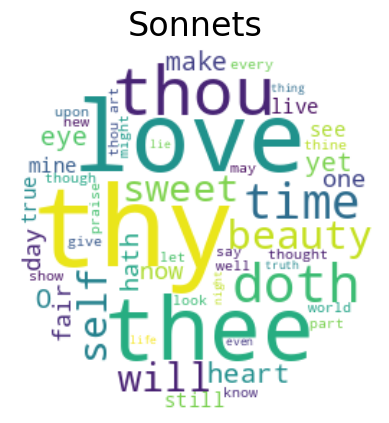

In [ ]:
wordcloud = text_to_wordcloud(shakespeare_text, title='Sonnets')

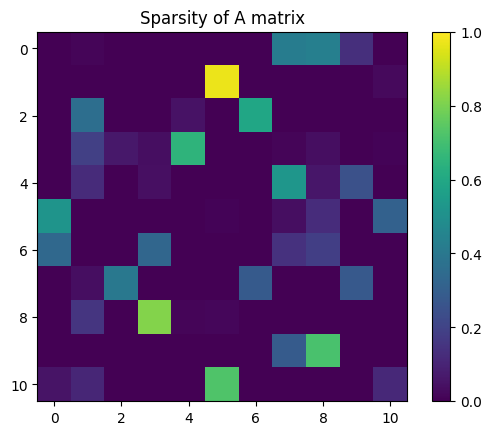

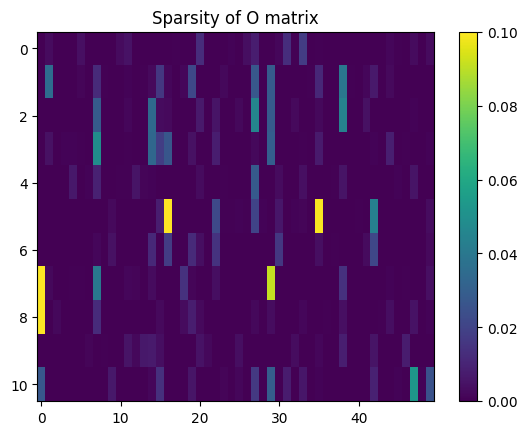

In [ ]:
visualize_sparsities(HMM, O_max_cols=50)

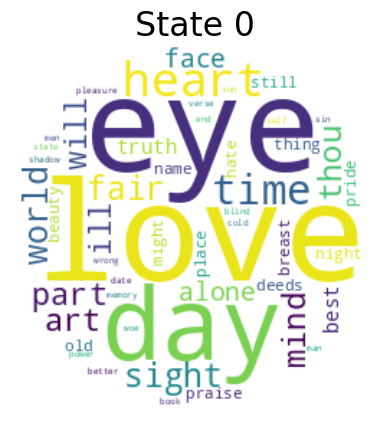

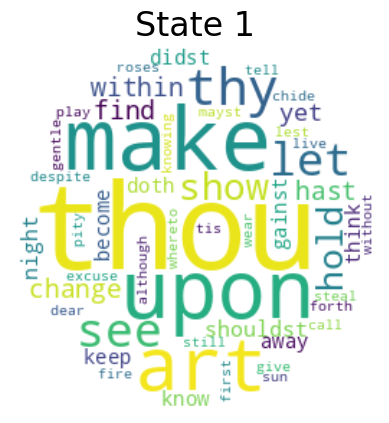

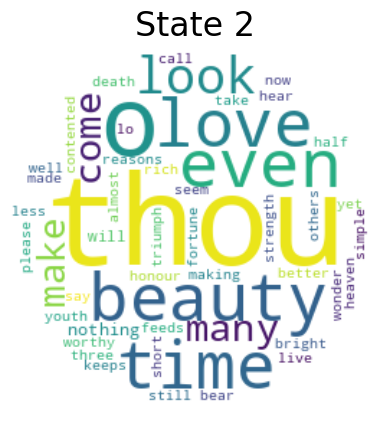

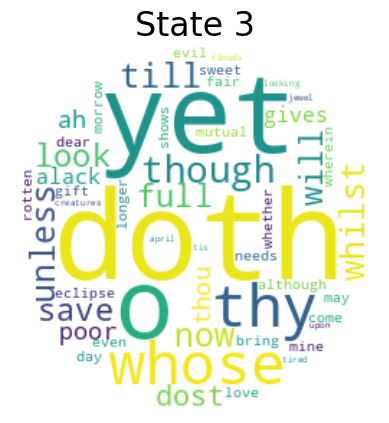

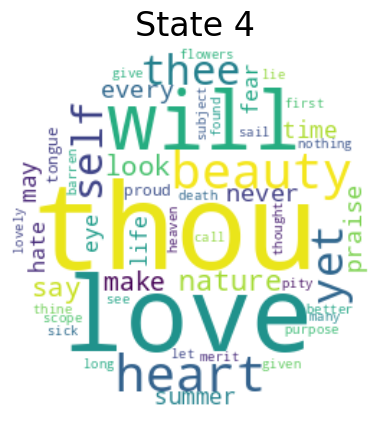

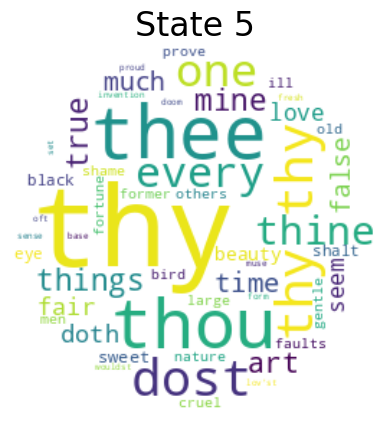

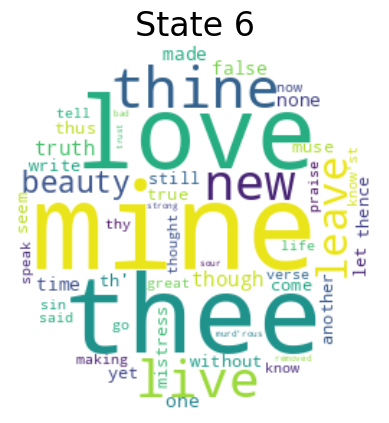

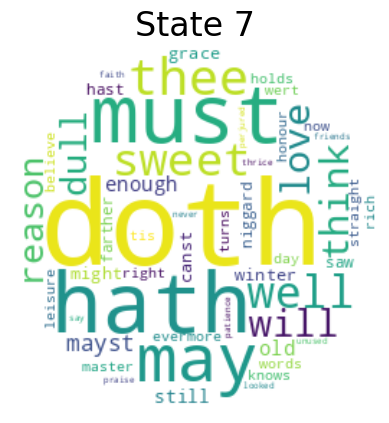

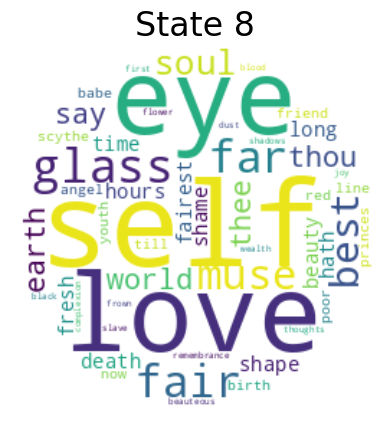

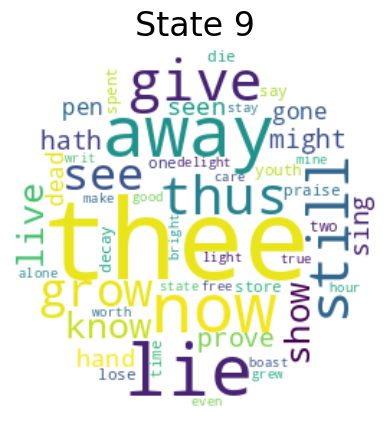

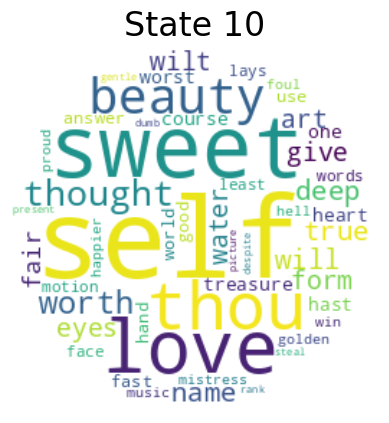

In [ ]:
wordclouds = states_to_wordclouds(HMM, word_to_idx, idx_to_word)

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
import pandas as pd

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


top 10 words for state 0: ['love', 'eyes', 'eye', 'heart', 'own', 'time', 'more', 'world', 'sight', 'day']
top 10 words for state 1: ['in', 'with', 'of', 'from', 'for', 'all', 'to', 'is', 'thou', 'on']
top 10 words for state 2: ['my', 'not', 'thou', 'with', 'but', 'o', 'to', 'that', 'be', 'your']
top 10 words for state 3: ['and', 'i', 'that', 'but', 'my', 'for', 'to', 'when', 'the', 'which']
top 10 words for state 4: ['i', 'thou', 'you', 'it', 'love', 'do', 'he', 'they', 'am', 'will']
top 10 words for state 5: ['the', 'thy', 'my', 'a', 'of', 'thee', 'your', 'his', 'their', 'thou']
top 10 words for state 6: ['so', 'me', 'which', 'mine', 'thee', 'no', 'a', 'you', 'than', 'her']
top 10 words for state 7: ['\n', 'to', 'of', 'in', 'that', 'not', 'is', 'are', 'doth', 'be']
top 10 words for state 8: ['\n', 'that', 'have', 'by', 'love', 'self', 'not', 'this', 'do', 'with']
top 10 words for state 9: ['thee', 'be', 'is', 'i', 'you', 'still', 'now', 'give', 'away', 'with']
top 10 words for state 

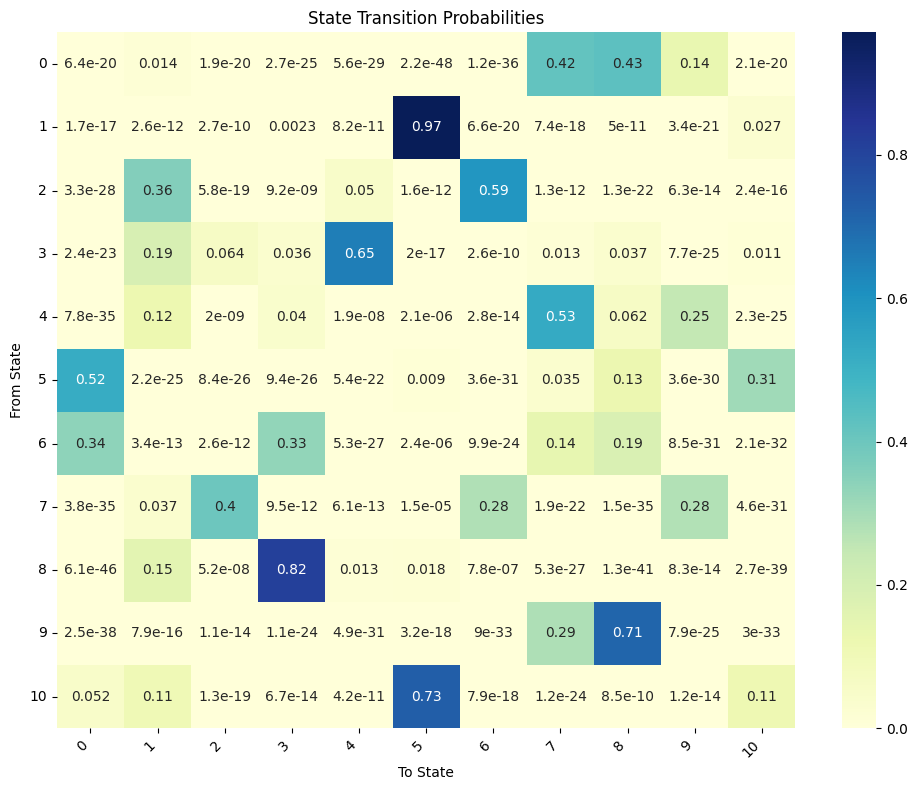

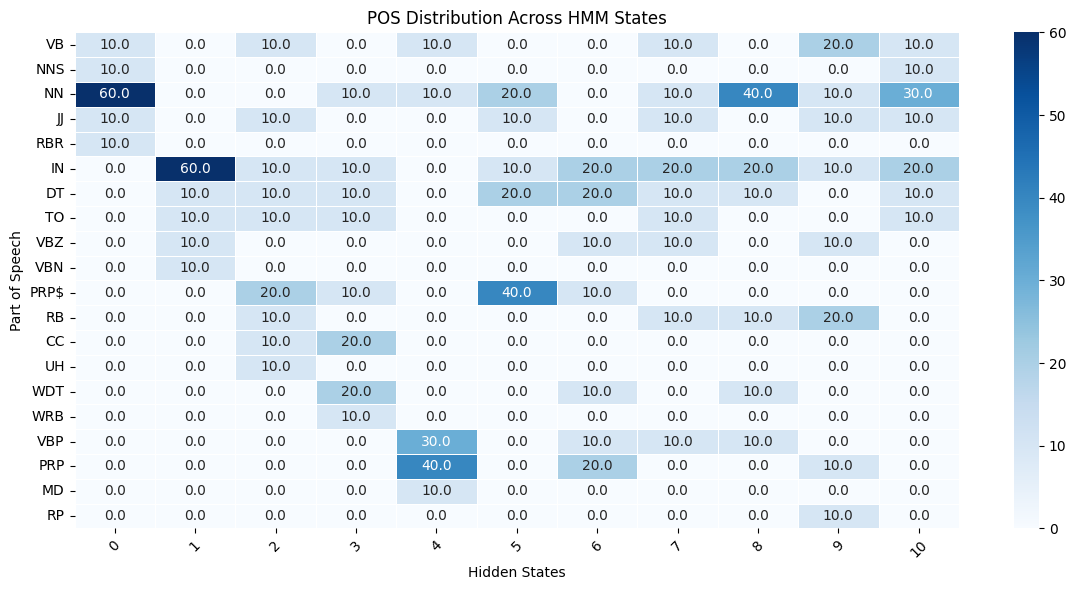

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tag import pos_tag
from collections import Counter

# Download NLTK resources
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')

def analyze_hmm_states(hmm_model, idx_to_word, n_top_words=10):
    """Analyze the hidden states of an HMM model"""

    observation_matrix = hmm_model.O
    state_words = {}
    for state_idx in range(len(observation_matrix)):
        state_probs = observation_matrix[state_idx]
        top_word_indices = np.argsort(state_probs)[-n_top_words:][::-1]
        top_words = [idx_to_word[idx] for idx in top_word_indices]
        state_words[state_idx] = top_words

    return state_words

def analyze_pos_distribution(state_words):
    """Analyze part-of-speech distribution for each state"""
    pos_distributions = {}

    for state, words in state_words.items():
        # Extract just the words (not probabilities)
        # word_list = [word for word, _ in words]

        # Get POS tags
        pos_tags = pos_tag(words)

        # Count tag frequencies
        tag_counter = Counter([tag for _, tag in pos_tags])
        total = sum(tag_counter.values())

        # Calculate percentages
        pos_distribution = {tag: count/total*100 for tag, count in tag_counter.items()}
        pos_distributions[state] = pos_distribution

    return pos_distributions

def visualize_transition_matrix(hmm_model, state_descriptions=None):
    """Visualize the state transition matrix"""
    transition_matrix = hmm_model.A

    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_matrix, annot=True, cmap="YlGnBu",
                xticklabels=state_descriptions, yticklabels=state_descriptions)
    plt.title("State Transition Probabilities")
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

# Analyze parts of speech
def visualize_pos_distribution(pos_distributions):
    """Visualize POS tag distributions as a heatmap."""
    pos_df = pd.DataFrame(pos_distributions).fillna(0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(pos_df, cmap="Blues", annot=True, fmt=".1f", linewidths=0.5)
    plt.title("POS Distribution Across HMM States")
    plt.xlabel("Hidden States")
    plt.ylabel("Part of Speech")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


#this is not working bc some import thing w/nltk but would be cool
state_words = analyze_hmm_states(HMM, idx_to_word)
for state, words in state_words.items():
    print(f"top 10 words for state {state}: {words}")

visualize_transition_matrix(HMM, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
pos_distributions = analyze_pos_distribution(state_words)
visualize_pos_distribution(pos_distributions)

Enforcing rhyming:

In [ ]:
emission, states = HMM.generate_sonnet_backwards(rhyme_dict, word_to_idx, idx_to_word, seed=seed)
words = [idx_to_word[i] for i in emission]
syll = count_syllables(words, syllable_dict, backwards=True)
print(syll)
print(' '.join(words))

[4, 16, 1, 1, 4, 30, 7, 1, 7, 15, 1, 4, 4, 28]

 Hopes in thine minds 
 Better the of self-killed in coral i no in 'tis if is you 
 Winds 
 Grew 
 World of day verse 
 Heart the look that wilt if green the worthless now when hence which can i you thy land my pure spring the cure time went with in that moan 
 Old an he eyes i inhearse 
 Gone 
 Ill that name that so lays breast 
 Once and in sweet the stol'n since oft view senses lips in of fame 
 Guest 
 Decay and name 
 When pleasant feature 
 Blood to thou why moods thy aught which there which why ranged is fairer thou joy restore whilst should till laid root lovers creature


Meter (additional goal #2):

In [ ]:
def supervised_HMM(X, Y, n_states, seed=None):

    rng = np.random.default_rng(seed=seed)

    observations = set()
    for x in X:
        observations |= set(x)
    L = n_states
    D = len(observations)


    A = [[rng.random() for _ in range(L)] for _ in range(L)]
    for i in range(L):
        norm = sum(A[i])
        for j in range(L):
            A[i][j] /= norm


    O = [[rng.random() for _ in range(D)] for _ in range(L)]
    for i in range(L):
        norm = sum(O[i])
        for j in range(D):
            O[i][j] /= norm


    hmm = HiddenMarkovModel(A, O)
    hmm.supervised_learning(X, Y)
    return hmm

num_hidden_states = 4
seed = random.randint(1, 10000)
labeled_states = [[0] * len(seq) for seq in tokenized_lines]
hmm_data = supervised_HMM(tokenized_lines, labeled_states, num_hidden_states, seed=seed)

In [ ]:
def state_stress_label(state):
    return "stressed" if state % 2 == 1 else "unstressed"

def get_syllable_count(word, syllable_dict, end_of_line=False):
    value = syllable_dict[word]
    if type(value) == int:
        return value
    if type(value) == list:
        if end_of_line:
            for candidate in value:
                if type(candidate) != int:
                    s = str(candidate)
                    if s.startswith('E'):
                        return int(s[1:])
            s = str(value[0])
            return int(s[1:]) if s.startswith('E') else int(s)
        else:
            for candidate in value:
                if type(candidate) == int:
                    return candidate
                s = str(candidate)
                if not s.startswith('E'):
                    return int(s)
            s = str(value[0])
            return int(s[1:]) if s.startswith('E') else int(s)
    s = str(value)
    if end_of_line:
        return int(s[1:]) if s.startswith('E') else int(s)
    else:
        return int(s[1:]) if s.startswith('E') else int(s)

def apply_meter_constraint(hmm):
    for i in range(hmm.L):
        for j in range(hmm.L):
            if state_stress_label(i) == "stressed" and state_stress_label(j) == "stressed":
                hmm.A[i][j] = 0
        row_sum = sum(hmm.A[i])
        if row_sum > 0:
            hmm.A[i] = [a / row_sum for a in hmm.A[i]]
        else:
            hmm.A[i] = [1 / hmm.L for _ in range(hmm.L)]

def sonnet_generate_emission_meter(hmm, num_syllables, syllable_dict, idx_to_word):
    emission = []
    states = []
    syllable_count = 0
    state = np.random.randint(0, hmm.L)
    while syllable_count < num_syllables:
        e = np.random.choice(range(hmm.D), p=hmm.O[state])
        word = idx_to_word[e]
        if word in syllable_dict:
            count = get_syllable_count(word, syllable_dict)
            if syllable_count + count <= num_syllables:
                emission.append(e)
                states.append(state)
                syllable_count += count
                state = np.random.choice(range(hmm.L), p=hmm.A[state])
    return emission, states

def generate_sonnet_meter(hmm, idx_to_word, syllable_dict, syllables_per_line=10):
    sonnet = ""
    for _ in range(14):
        emission, _ = sonnet_generate_emission_meter(hmm, syllables_per_line, syllable_dict, idx_to_word)
        words = [idx_to_word[i] for i in emission]
        # Recount syllables for verification.
        total_syllables = sum(get_syllable_count(word, syllable_dict) for word in words if word in syllable_dict)
        line_str = " ".join(words)
        sonnet += f"(syllables: {total_syllables}) {line_str}\n"
    print(sonnet)

def generate_metered_poem(hmm, idx_to_word, syllable_dict, syllables_per_line=10, num_lines=14):
    apply_meter_constraint(hmm)

    poem_lines = []
    for _ in range(num_lines):
        # Generate an emission that meets the syllable target.
        emission, _ = sonnet_generate_emission_meter(hmm, syllables_per_line, syllable_dict, idx_to_word)
        # Convert indices to words and filter out stray newlines or blank tokens.
        words = [idx_to_word[i] for i in emission if idx_to_word[i].strip() != "" and idx_to_word[i] != "\n"]
        if not words:
            continue

        total_syllables = 0
        for i, word in enumerate(words):
            if word in syllable_dict:
                if i == len(words) - 1:
                    total_syllables += get_syllable_count(word, syllable_dict, end_of_line=True)
                else:
                    total_syllables += get_syllable_count(word, syllable_dict, end_of_line=False)
        line = " ".join(words)
        poem_lines.append(f"(syllables: {total_syllables}) {line}")


    poem = "\n".join(poem_lines)
    print(poem)

generate_metered_poem(hmm_data, idx_to_word, syllable_dict, syllables_per_line=10)

(syllables: 10) know in and against tongues neither no my
(syllables: 10) revenues earth fame mortality too
(syllables: 10) an thrice in of survey doth doth o worth
(syllables: 10) says reign heart's steal one pain successive thee
(syllables: 10) expressed me doctor-like on in and all
(syllables: 10) grind which poor like new was accessary
(syllables: 10) hideous force in to consider which all
(syllables: 10) harvest receives robs flower towards nought compounds
(syllables: 10) banks numbers records sorrows falsely ill
(syllables: 10) let sweetest kind time's adieu captain with
(syllables: 10) out tells please philomel with as dumb the
(syllables: 10) used fair beauty away think of time
(syllables: 10) proceed rise dare o'er-green their that mayst will
(syllables: 10) strength elements came creatures me see which
